$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\ketbra}[2]{| #1\rangle \langle #2|} $
$ \newcommand{\tr}{{\rm tr}} $
$ \newcommand{\i}{{\color{blue} i}} $
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\V}{{\cal V}} $
$ \newcommand{\bn}{{\bf n}} $

# 4. Two-qubit driving

Entanglement is one of the pillars behind quantum computing. On this notebook we will explore how the entanglement between qubit systems is physically achieved with pulses, which are the most common methods and how to implement some of them with OpenPulse.

## 4.1. The CR and ECR gates

There are many methods to produce entanglement between superconducting qubits, usually grouped in two families: one using local magnetic fields to tune transition frequencies, and other that only relies on microwave control. Here we'll focus on the only-microwave gates, as they are the ones that Qmio can perform.<br>
<br>

Let's assume we have a physical channel that allows the coupling of qubits, and that these qubits were prepared with different resonant frequencies. What would happen if we drived one qubit with the other's frequency?<br>
<br>

Extending the driving Hamiltonian formulation of the single qubit gate, we arrive to this Hamiltonian that represents the effects of the driving on the first qubit (1):
$$H_{d,1}=\Omega V_{d,1}(t)\left(\sigma_x\otimes I + \nu_1 I\otimes\sigma_x+\mu_1\sigma_z\otimes\sigma_x\right),$$
where $V_{d,1}(t)$ is the oscillating potential generating the driving and $\nu$ and $\mu$ are some constants that depend on the coupling of the qubits, the frequency difference and anharmonicity. One key assumtion is that the frequency difference is much greater that the coupling. If we drive the qubit 1 with the frequency of qubit 2, we can supress the usual Rabi oscillation on 1: 
$$\begin{align*}
H_{d,1}^{(\omega_2)}=\Omega V_{d,1}^{(\omega_2)}(t)\left(\nu_1 I+\mu_1\sigma_z\right)\otimes\sigma_x,
\end{align*}$$
which means that this pulse will produce a Rabi oscillation on qubit 2 with a period that depends on the state of qubit 1. <br>
<br>

The ideal unitary transformation over the 2-qubit space it's call **cross-resonance gate** (CR), and can be expressed as:

$$U_{CR_\theta}=
\begin{pmatrix}
\cos\theta/2 & -i\sin\theta/2 & 0 & 0\\
-i\sin\theta/2 & \cos\theta/2 & 0 & 0\\
0 & 0 & \cos\theta/2 & i\sin\theta/2\\
0 & 0 & i\sin\theta/2 & \cos\theta/2
\end{pmatrix}\equiv ZX_\theta,$$
where $\theta=-\mu_1\omega V_{d,1}(t)$.<br>
<br>

Nevertheless, the effect of the off-resonance driving produces significant effects on the driven qubit like AC Stark shift, the coherent error induced by the $\sigma_z\otimes I$ term or the leakeage to higher energy levels. These effects reduce the fidelity of the gate. One method to overcome some of this complications it's the so-called **echo cross-resonance gate** (ECR), which consists of a modified pulse schedule to echo away this interactions. This modified version of the gate has been found to increase the fidelity for the desired unitary gate, and is the native entanglement gate at Qmio, which is calibrated along the SX. <br>
<br>

The pulse shcedule consists of CR pulses applied to the control qubit, along with rotations over the X axis also on the control qubit:

<br>
<figure style="text-align: center; margin: auto; max-width: 720px;">
    <img src="./media/ecr_schedule.png" width="500" alt="ECR Schedule" style="display: block; margin: 0 auto;">
    <figcaption style="margin-top: 12px; font-size: 0.9em; color: #444; line-height: 1.5; text-align: left;">
        a. ECR pulse schedule: two cross-resonance tones (gray) applied on the control qubit with the target's resonance frequency; each followed by a pi-pulse on the control. <br> 
        b. Action of each pulse on the target at |0> depending on the arbitrary control state over the Bloch sphere.<br>
        c. Evolution of the transmon's level populations, depending on the control state, across the pulse schedule.<br>
        [1] https://doi.org/10.1103/PRXQuantum.4.030327 
    </figcaption>
</figure>
<br>




## 4.2. Multi-qubit driving with OpenPulse

When working with entangling gates on real hardware, the first thing we need to have in mind is the QPU connectivity. The current logical qubit connectivity can be checked at the [Qmio User Guide](https://cesga-docs.gitlab.io/qmio-user-guide/installation_overview.html):

<br>
<figure style="text-align: center; margin: auto; max-width: 720px;">
    <img src="./media/qmio_connectivity.png" width="500" alt="Qmio Connectivity" style="display: block; margin: 0 auto;">
    <figcaption style="margin-top: 12px; font-size: 0.9em; color: #444; line-height: 1.5; text-align: center;">
        Qmio's QPU logical qubit connectivity, from Qmio User Guide.
    </figcaption>
</figure>
<br>

It's important to note that the qubit IDs we use in OpenPulse are the physical qubits. The logic to physical correspondence is a simple mapping:

    Logical ID’s: from 0-31

    Physica ID’s: from 1-35  (1, 10 and 16 missing)

For example, if we wanted to use the logical $0\rightarrow 1$, we would use the physical qubits 2 and 3, as the physical qubit 1 is not currently available.

<br>
<figure style="text-align: center; margin: auto; max-width: 720px;">
    <img src="./media/qmio_physical_connectivity.png" width="500" alt="Qmio Connectivity" style="display: block; margin: 0 auto;">
    <figcaption style="margin-top: 12px; font-size: 0.9em; color: #444; line-height: 1.5; text-align: center;">
        Qmio's QPU physical qubit connectivity.
    </figcaption>
</figure>
<br>

### Cross-resonance driving

Before implementing the ECR gate, let's see how the cross-resonance driving works. First, we set up our Qmio workspace:

In [1]:
from qmio import QmioRuntimeService
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

service = QmioRuntimeService()

def run_instruction(_backend, _instruction, _shots):  
        _res = _backend.run(circuit = _instruction, shots = _shots, res_format = 'raw')     
        try :
            return _res["results"]                                      
        except :
            print(_res) 

We are going to perform the CR between the qubit **2 (control)** and **3 (target)**. This means that we will drive qubit 2 with the resonance frequency of qubit 3. To do this, we need two OpenPulse functions:

- ```get_frequency(frame)```: returns the resonance frequency of a qubit frame as a float.

- ```newframe(port/frame, frequency, phase)```: creates a new qubit frame from an existing one, specifying its new frequency an accrued relative phase. 

Here, we'll use some selected amplitude and duration for the pulse in order to visualize the gate's effect, later we'll perform a proper calibration. 

In [2]:
q_control = 2 # control
q_target = 3 # target


'''Pulse parameters '''
amp_cr = 0.5051
duration_cr = 250 # dt

inst = f'''OPENQASM 3;
    defcalgrammar "openpulse";

    cal {{
        extern frame q{q_control}_drive;    // import control qubit frame
        extern frame q{q_target}_drive;     // import target qubit frame

        target_freq = get_frequency(q{q_target}_drive);                     // import target qubit frequency from frame
        frame cr_frame = newframe(q{q_control}_drive,  target_freq, 0.0);   // create new frame on the control qubit with the target frequency
        waveform wf_cr = constant({duration_cr}dt, {amp_cr});               // define the pulse waveform
    }}

    defcal CR_control ${q_control}, ${q_target}{{ // the defcal function must specify both qubit, to apply the implicit time barrier
        play(cr_frame, wf_cr);                    // play the pulse schedule over the control qubit
    }}

    x ${q_control};                         // apply a calibrated X gate on the control qubit
    CR_control ${q_control}, ${q_target};   // apply the CR pulse on the control qubit
    measure ${q_control};                   // measure both qubits
    measure ${q_target};'''

In [4]:
shots = 1000
with service.backend(name = "qpu") as backend:
    res = run_instruction(backend, inst, shots)

Waiting for resources


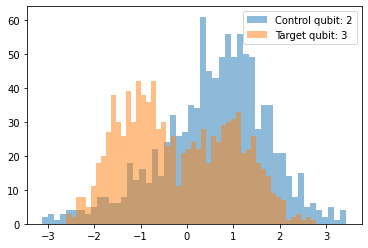

In [5]:
plt.hist(res[0].reshape(shots,), bins = 50, alpha = 0.5, label = f'Control qubit: {q_control}')
plt.hist(res[1].reshape(shots,), bins = 50, alpha = 0.5, label = f'Target qubit: {q_target}')
plt.legend()
plt.show()

## References

- [1] Fischer, L. E., Chiesa, A., Tacchino, F., Egger, D. J., Carretta, S., & Tavernelli, I. (2023). Universal Qudit Gate Synthesis for Transmons. PRX Quantum, 4(3), 030327. https://doi.org/10.1103/PRXQuantum.4.030327 

- [2] P. Krantz, M. Kjaergaard, F. Yan, T. P. Orlando, S. Gustavsson, W. D. Oliver; A quantum engineer's guide to superconducting qubits. Appl. Phys. Rev. 1 June 2019; 6 (2): 021318. https://doi.org/10.1063/1.5089550